# A simple chain for getting answers from a database

### Load the environment variables needed for the application

In [1]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

### Connect to a database to have an access to the data

In [2]:
from langchain_community.utilities import SQLDatabase

# Define the database URI
db_uri = "sqlite:///chinook.db"

# Create a database object
db = SQLDatabase.from_uri(db_uri)

# Test the connection by printing dialect, listing table names and querying the database
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

### Instantiate LLM model

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

### Load the tools

In [4]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# Load the SQL tools for AI agent to use
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

### Define a State class to preserve all the required valriables accross the steps

In [5]:
from langgraph.graph import MessagesState

### Pull the prebuilt prompt template for sql query generation

In [6]:
message_template = """
    You are an agent designed to interact with a SQL database.
    Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
    Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
    You can order the results by a relevant column to return the most interesting examples in the database.
    Never query for all the columns from a specific table, only ask for the relevant columns given the question.
    You have access to tools for interacting with the database.
    Only use the below tools. Only use the information returned by the below tools to construct your final answer.
    You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

    DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

    To start you should ALWAYS look at the tables in the database to see what you can query.
    Do NOT skip this step.
    Then you should query the schema of the most relevant tables.
    """

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=message_template)

llm_with_tools = llm.bind_tools(tools)

### Build a LangGraph graph (router)

In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Initialize in-memory checkpointer
memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

# Compile graph
graph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

### Visual representation of the graph

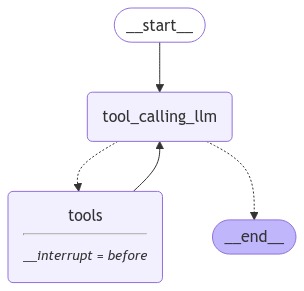

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the graph by providing a question

In [9]:
# Input
initial_input = {"messages": HumanMessage(content="How many customers we have?")}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

state = graph.get_state(config)
while state.next[0] == 'tools' and event['messages'][-1].tool_calls[0]['name'] != "sql_db_query":
    for event in graph.stream(None, config, stream_mode="values"):
        print(event['messages'][-1])
    try:
        state_next = state.next[0]
    except:
        state_next = ""

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()

================================ Human Message =================================

How many customers we have?


Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')trace=ed518990-5f86-4afd-b93f-001af234f343,id=ed518990-5f86-4afd-b93f-001af234f343; trace=ed518990-5f86-4afd-b93f-001af234f343,id=fbc6bd11-0179-494f-bf24-eb5b35320b2b; trace=ed518990-5f86-4afd-b93f-001af234f343,id=edc16522-27cc-4321-8786-0b9b814263b9; trace=ed518990-5f86-4afd-b93f-001af234f343,id=7dafd27f-bdd2-4571-9b50-9c5985a0211c; trace=ed518990-5f86-4afd-b93f-001af234f343,id=d8601c3d-f121-460f-9202-a859eb73195a; trace=ed518990-5f86-4afd-b93f-001af234f343,id=c942c2dc-6599-4807-9219-a8e8732cda4e


================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_kB97lo4TYp3O90HeHF5Av24w)
 Call ID: call_kB97lo4TYp3O90HeHF5Av24w
  Args:
content='' additional_kwargs={'tool_calls': [{'id': 'call_kB97lo4TYp3O90HeHF5Av24w', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 561, 'total_tokens': 574, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-c942c2dc-6599-4807-9219-a8e8732cda4e-0' tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_kB97lo4TYp3O90HeHF5Av24w', 'type': 'tool_call'}] usage_metadata={'i

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')


content='' additional_kwargs={'tool_calls': [{'id': 'call_P7B7BmnNvkboJm7pPaiPWeqf', 'function': {'arguments': '{"table_names":"Customer"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 607, 'total_tokens': 624, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7824c46d-e771-440b-af50-47c80e9642bc-0' tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Customer'}, 'id': 'call_P7B7BmnNvkboJm7pPaiPWeqf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 607, 'output_tokens': 17, 'total_tokens': 624, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 're

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')


content='```sql\nSELECT COUNT(*) as customer_count FROM Customer;\n```' name='sql_db_query_checker' id='be5ccbef-e264-4f5f-9796-671d63e8dcbe' tool_call_id='call_G4Qs1PoMX8XIcCSqPgDtLRm4'
content='' additional_kwargs={'tool_calls': [{'id': 'call_k0ndOiWxGBOYW1mPM4kGqOeb', 'function': {'arguments': '{"query":"SELECT COUNT(*) as customer_count FROM Customer;"}', 'name': 'sql_db_query'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1081, 'total_tokens': 1105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-e7007209-6989-447d-9901-7a196484aa04-0' tool_calls=[{'name': 'sql_db_query', 'args': {'query': 'SELECT COUNT(*) as customer_cou

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')


================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_k0ndOiWxGBOYW1mPM4kGqOeb)
 Call ID: call_k0ndOiWxGBOYW1mPM4kGqOeb
  Args:
    query: SELECT COUNT(*) as customer_count FROM Customer;
================================= Tool Message =================================
Name: sql_db_query

[(59,)]
================================== Ai Message ==================================

There are a total of 59 customers in the database.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Monthly unique traces usage limit exceeded"}')
